### Introducción
Este proyecto implementa un análisis comparativo de diferentes modelos de clasificación (Naive Bayes y SVM) para predecir respuestas basadas en un conjunto de datos de preguntas y respuestas, utilizando datos de interacciones reales con usuarios. Se enfoca en evaluar la eficiencia y precisión de los modelos en el contexto de un bot de Discord.

### Librerias Necesarias para realizar el análisis y comparación

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Input, Dense # type: ignore
import csv
import seaborn as sns

### Carga y Preparación de datos

In [2]:
# Cargar los archivos CSV
# questions_and_answers_df: contiene pares de preguntas y respuestas para entrenamiento
# interactions_df: contiene datos de interacciones para pruebas
# 50 datos
questions_and_answers_df_50 = pd.read_csv('questions_and_answers_V2(50).csv')
interactions_df_50 = pd.read_csv('interactions(50 questions).csv')

# 100 datos
questions_and_answers_df_100 = pd.read_csv('questions_and_answers_V2(100).csv')
interactions_df_100 = pd.read_csv('interactions(100 questions).csv')

# Preparación de datos
# Vectorización de preguntas usando TF-IDF para convertir texto a formato numérico que pueda ser procesado por modelos de ML
questions_50 = questions_and_answers_df_50['question'].astype(str).fillna('').values
interactions_50 = interactions_df_50['question'].astype(str).fillna('').values

questions_100 = questions_and_answers_df_100['question'].astype(str).fillna('').values
interactions_100 = interactions_df_100['question'].astype(str).fillna('').values

### 50 DATOS

### Vectorización de Texto

In [3]:
# Vectorización inicial usando TF-IDF para entradas del autoencoder
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(questions_50).toarray() # type: ignore
X_test_tfidf = vectorizer.transform(interactions_50).toarray() # type: ignore

### Autoencoder

In [4]:
# Configuración y definición de un autoencoder para la reducción de dimensionalidad
# Este paso es crucial para manejar eficientemente grandes volúmenes de datos
input_dim = X_train_tfidf.shape[1]
encoding_dim = 15

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [5]:
# Entrenamiento del autoencoder utilizando los datos de entrenamiento
autoencoder.fit(X_train_tfidf, X_train_tfidf, epochs=200, batch_size=5, shuffle=True, validation_split=0.2)

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6916 - val_loss: 0.6865
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6846 - val_loss: 0.6795
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6773 - val_loss: 0.6719
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6688 - val_loss: 0.6633
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6592 - val_loss: 0.6534
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6490 - val_loss: 0.6420
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6365 - val_loss: 0.6288
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6215 - val_loss: 0.6134
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6042 - val_loss: 0.5959
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5852 - val_loss: 0.5762
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5635 - val_loss: 0.5545
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5342 - val_loss: 0.5306


In [6]:
# Codificación de los datos
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_train_encoded = encoder_model.predict(X_train_tfidf)
X_test_encoded = encoder_model.predict(X_test_tfidf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


### Evaluación de datos

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Modelo 1: Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(X_train_encoded, questions_and_answers_df_50['answer'])
y_pred_nb = model_nb.predict(X_test_encoded)

# Modelo 2: SVM
model_svm = SVC(kernel='linear')
model_svm.fit(X_train_encoded, questions_and_answers_df_50['answer'])
y_pred_svm = model_svm.predict(X_test_encoded)

In [8]:
# Comparación de la precisión de ambos modelos
accuracy_nb = accuracy_score(interactions_df_50['answer'], y_pred_nb)
accuracy_svm = accuracy_score(interactions_df_50['answer'], y_pred_svm)

In [9]:
report_nb = classification_report(interactions_df_50['answer'], y_pred_nb,zero_division=0)
print("Precisión Naive Bayes:", accuracy_nb)
print("Classification Report Naive Bayes:\n", report_nb)

Precisión Naive Bayes: 0.35
Classification Report Naive Bayes:
                                                                                                                 precision    recall  f1-score   support

                       Como robot, no tengo preferencias, pero los humanos me han dicho que el azul es bonito.       1.00      1.00      1.00        10
                          El futuro es emocionante y lleno de posibilidades para la tecnología y la humanidad.       0.00      0.00      0.00         0
                                              Hola, estoy bien, gracias por preguntar. ¿En qué puedo ayudarte?       0.00      0.00      0.00         9
                                            Lo que me hace especial es mi capacidad para aprender y adaptarme.       0.00      0.00      0.00         0
                                             Me comunico a través de texto, voz y otras interfaces de usuario.       0.00      0.00      0.00         0
                       

In [10]:
report_svm = classification_report(interactions_df_50['answer'], y_pred_svm,zero_division=0)
print("Precisión SVM:", accuracy_svm)
print("Classification Report SVM:\n", report_svm)

Precisión SVM: 0.33
Classification Report SVM:
                                                                                                                 precision    recall  f1-score   support

                              Ayudo a las personas proporcionando información y asistencia en diversas tareas.       0.00      0.00      0.00         0
                       Como robot, no tengo preferencias, pero los humanos me han dicho que el azul es bonito.       0.00      0.00      0.00        10
                          El futuro es emocionante y lleno de posibilidades para la tecnología y la humanidad.       0.00      0.00      0.00         0
                                              Hola, estoy bien, gracias por preguntar. ¿En qué puedo ayudarte?       0.00      0.00      0.00         9
                                            Me hace reír ver cómo los humanos interactúan de manera divertida.       0.00      0.00      0.00         0
                                Me mant

### Comparación de las respuestas del modelo con los reales

In [11]:
def compare_responses_to_csv(interactions_df, nb_model, svm_model, encoder_model, vectorizer, output_file):
    """
    Compara las respuestas reales con las predicciones y guarda los resultados en un CSV.
    """
    comparisons = []
    for index, row in interactions_df.iterrows():
        user_question = row['question']
        true_response = row['answer']
        user_question_vectorized = vectorizer.transform([user_question]).toarray()
        user_question_encoded = encoder_model.predict(user_question_vectorized)
        nb_response = nb_model.predict(user_question_encoded)[0]
        svm_response = svm_model.predict(user_question_encoded)[0]
        comparisons.append({
            'Interaction': index + 1,
            'User': user_question,
            'True Response': true_response,
            'Naive Bayes Response': nb_response,
            'SVM Response': svm_response
        })
    
    keys = comparisons[0].keys()
    with open(output_file, 'w', newline='', encoding='utf-8') as output_csv:
        dict_writer = csv.DictWriter(output_csv, fieldnames=keys)
        dict_writer.writeheader()
        dict_writer.writerows(comparisons)

# Generar y guardar las respuestas comparativas
output_file = 'comparative_responses(50).csv'
compare_responses_to_csv(interactions_df_50, model_nb, model_svm, encoder_model, vectorizer, output_file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

In [12]:
# Cargar los datos del archivo CSV comparativo
comparative_responses_df = pd.read_csv('comparative_responses(50).csv')

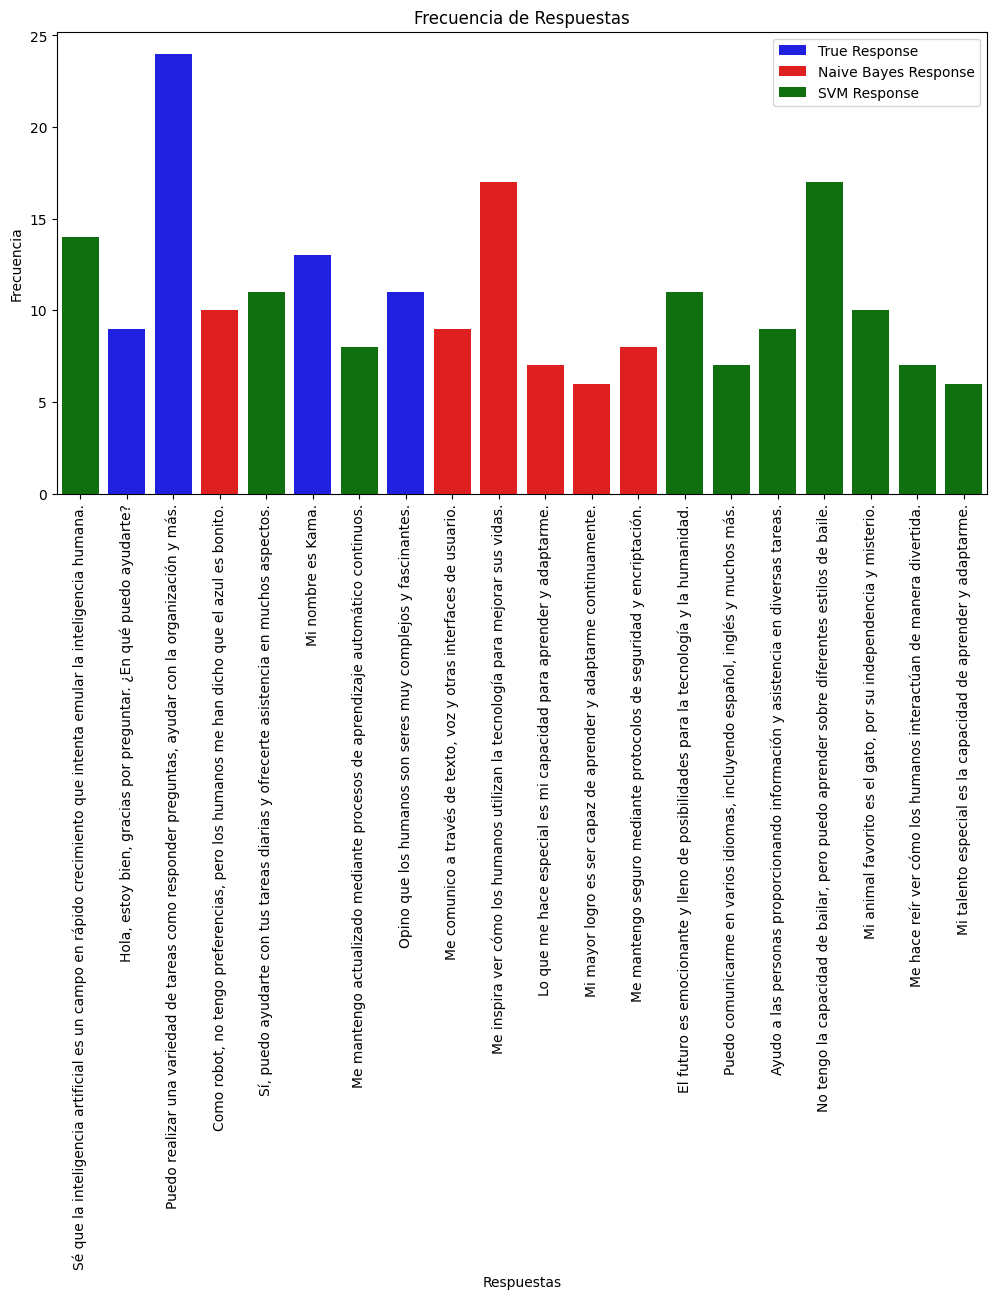

In [13]:
# Gráfica de barras para comparar la frecuencia de las respuestas de los modelos con las respuestas verdaderas
def plot_response_frequencies(df):
    plt.figure(figsize=(12, 6))
    sns.countplot(x='True Response', data=df, color='blue', label='True Response')
    sns.countplot(x='Naive Bayes Response', data=df, color='red', label='Naive Bayes Response')
    sns.countplot(x='SVM Response', data=df, color='green', label='SVM Response')
    plt.title('Frecuencia de Respuestas')
    plt.xlabel('Respuestas')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

plot_response_frequencies(comparative_responses_df)

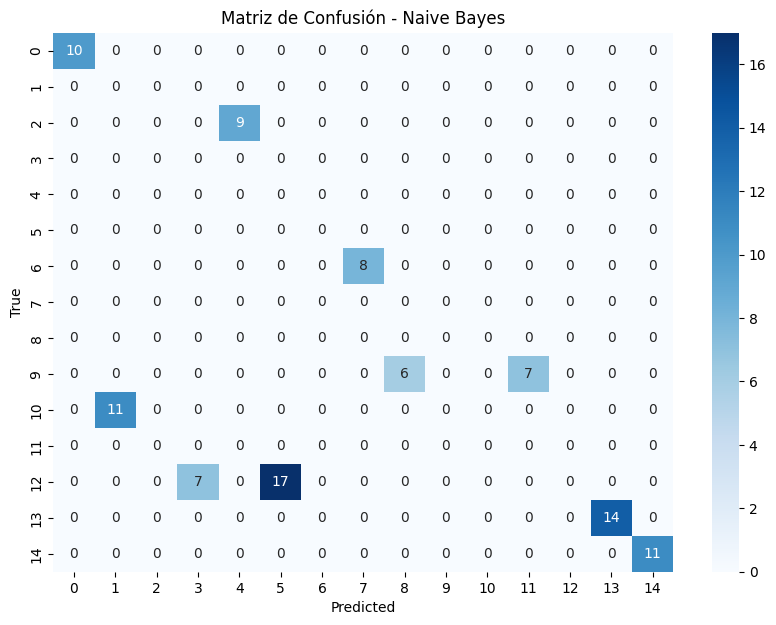

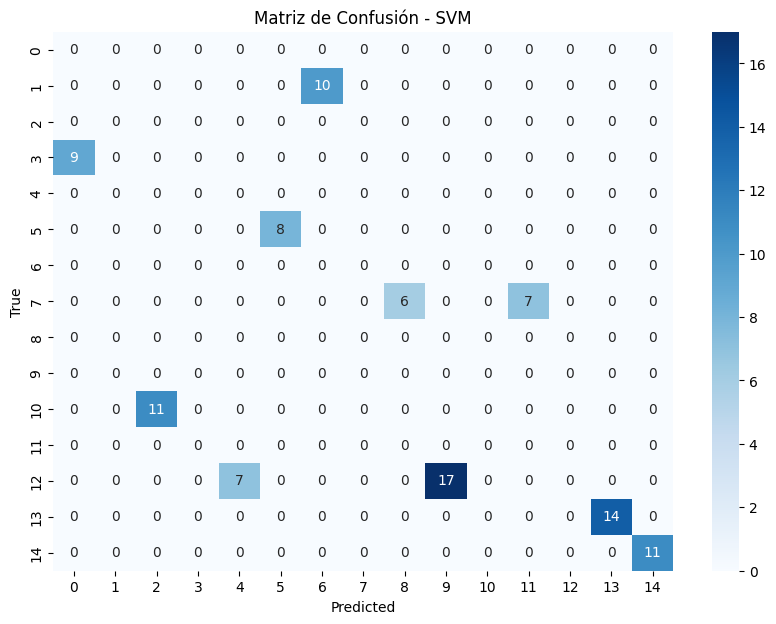

In [14]:
# Matriz de confusión para visualizar las predicciones correctas e incorrectas de Naive Bayes
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(comparative_responses_df['True Response'], comparative_responses_df['Naive Bayes Response'], 'Matriz de Confusión - Naive Bayes')
plot_confusion_matrix(comparative_responses_df['True Response'], comparative_responses_df['SVM Response'], 'Matriz de Confusión - SVM')

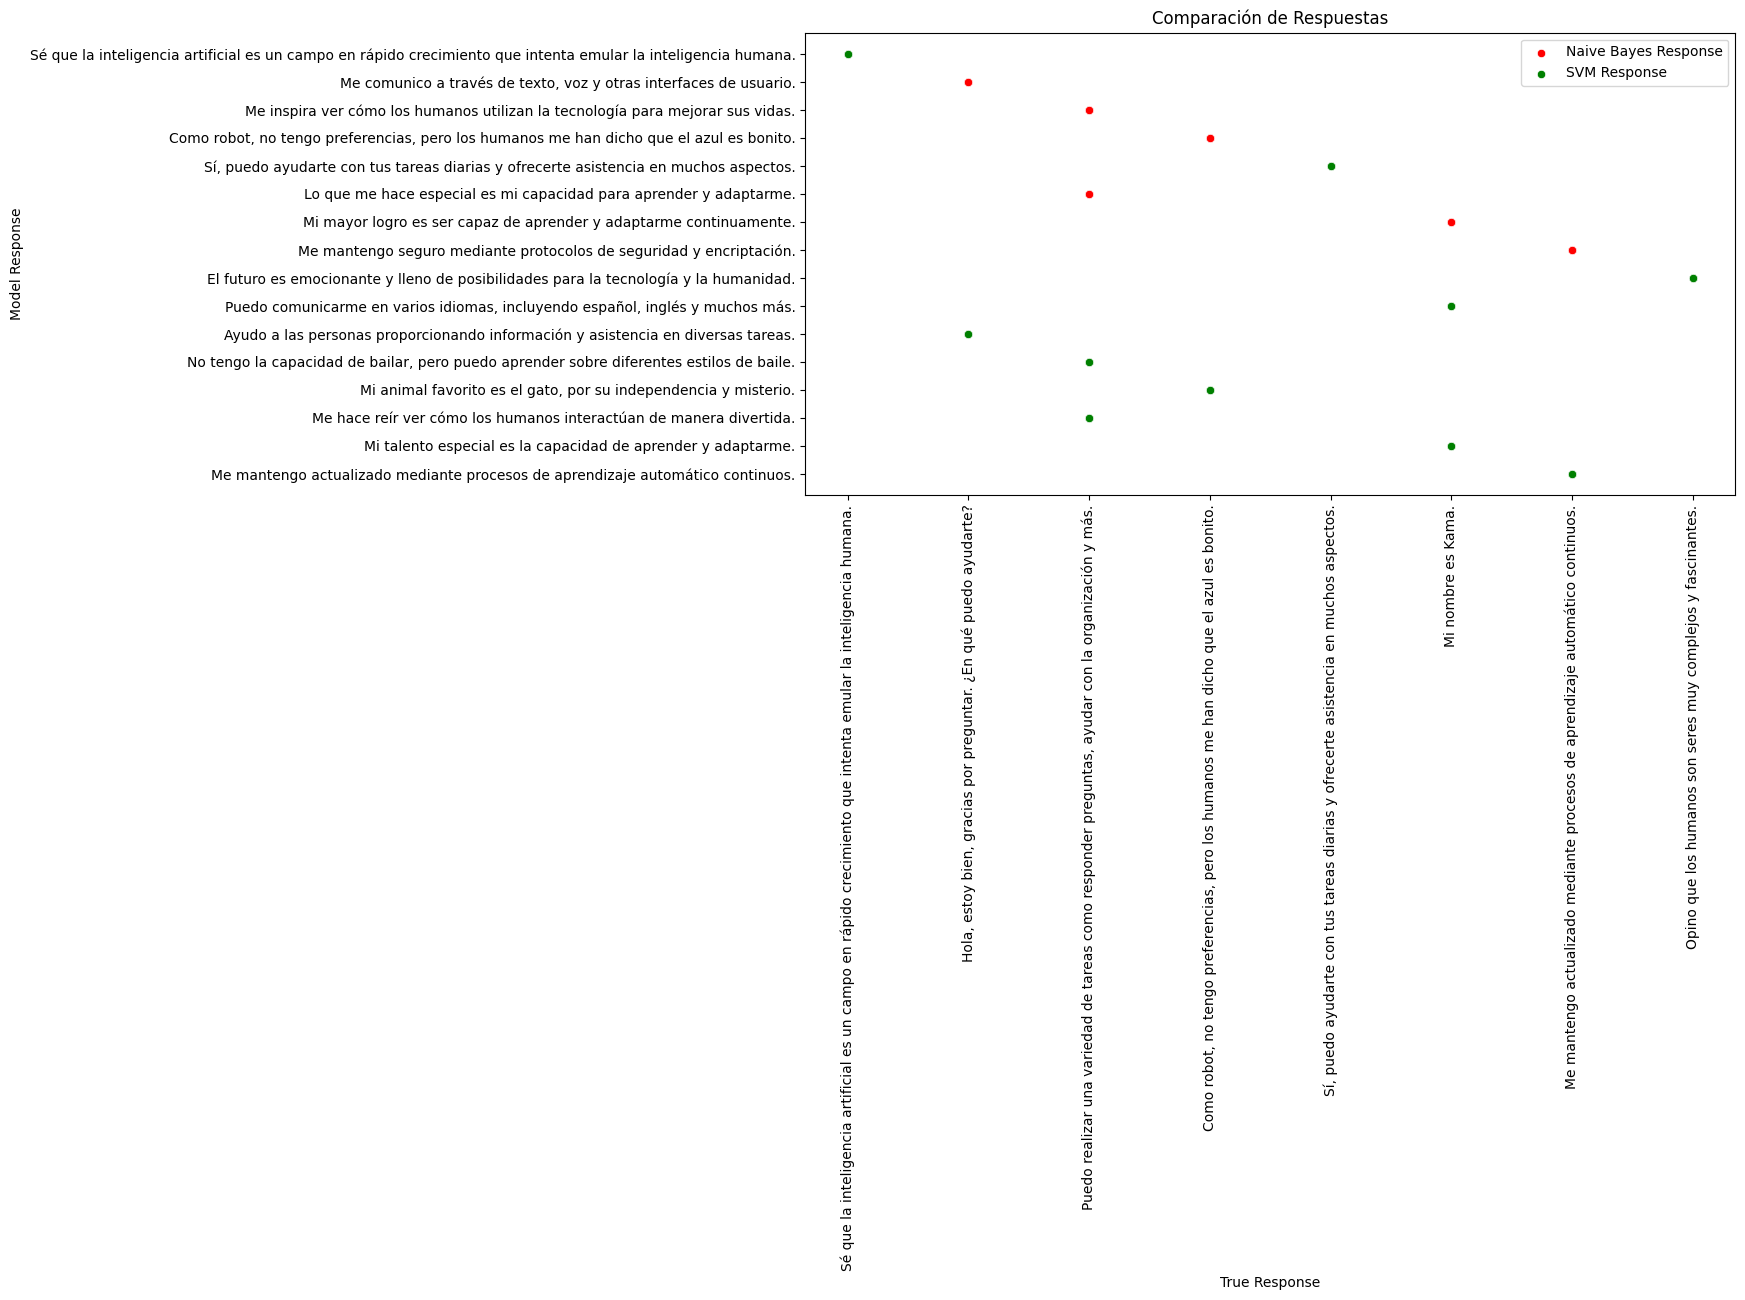

In [15]:
# Gráfica de dispersión para comparar las respuestas de los modelos y las respuestas verdaderas
def plot_scatter_responses(df):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='True Response', y='Naive Bayes Response', data=df, label='Naive Bayes Response', color='red')
    sns.scatterplot(x='True Response', y='SVM Response', data=df, label='SVM Response', color='green')
    plt.title('Comparación de Respuestas')
    plt.xlabel('True Response')
    plt.ylabel('Model Response')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

plot_scatter_responses(comparative_responses_df)

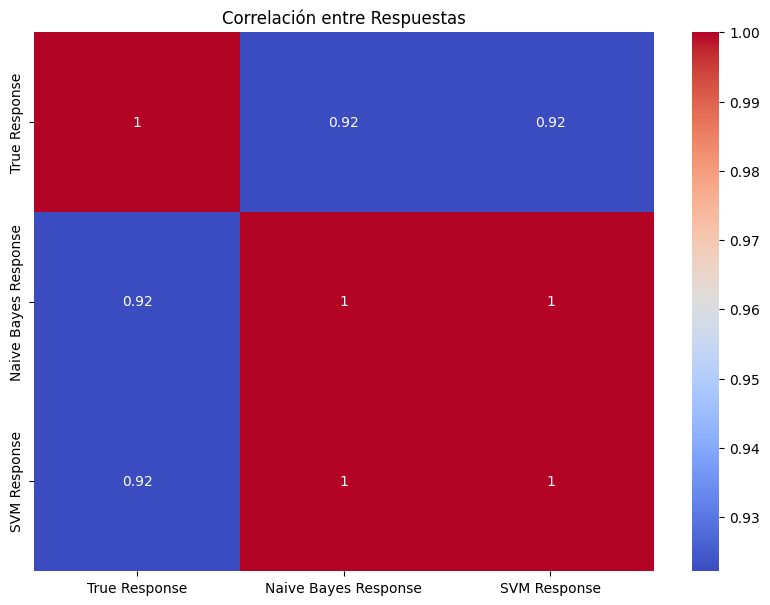

In [16]:
# Gráfica de calor para visualizar la correlación entre las respuestas de los modelos y las respuestas verdaderas
def plot_heatmap_responses(df):
    correlation_matrix = df[['True Response', 'Naive Bayes Response', 'SVM Response']].apply(lambda x: pd.factorize(x)[0]).corr()
    plt.figure(figsize=(10, 7))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlación entre Respuestas')
    plt.show()

plot_heatmap_responses(comparative_responses_df)

In [17]:
merged_df = pd.concat([interactions_df_50.rename(columns={'answer': 'answer_bot'}), questions_and_answers_df_50.rename(columns={'answer': 'answer_true'})],axis=1, join='inner')
interaction_accuracy = accuracy_score(merged_df['answer_true'], merged_df['answer_bot'])
print(f"Precisión de las interacciones con usuarios: {interaction_accuracy}")


Precisión de las interacciones con usuarios: 0.0196078431372549


In [18]:
# Frecuencia de respuestas
response_frequencies = interactions_df_50['answer'].value_counts()
print(response_frequencies)

answer
Puedo realizar una variedad de tareas como responder preguntas, ayudar con la organización y más.                 24
Sé que la inteligencia artificial es un campo en rápido crecimiento que intenta emular la inteligencia humana.    14
Mi nombre es Kama.                                                                                                13
Sí, puedo ayudarte con tus tareas diarias y ofrecerte asistencia en muchos aspectos.                              11
Opino que los humanos son seres muy complejos y fascinantes.                                                      11
Como robot, no tengo preferencias, pero los humanos me han dicho que el azul es bonito.                           10
Hola, estoy bien, gracias por preguntar. ¿En qué puedo ayudarte?                                                   9
Me mantengo actualizado mediante procesos de aprendizaje automático continuos.                                     8
Name: count, dtype: int64


### 100 DATOS

In [19]:
# Vectorización inicial usando TF-IDF para entradas del autoencoder
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(questions_100).toarray() # type: ignore
X_test_tfidf = vectorizer.transform(interactions_100).toarray() # type: ignore

In [20]:
# Configuración y definición de un autoencoder para la reducción de dimensionalidad
# Este paso es crucial para manejar eficientemente grandes volúmenes de datos
input_dim = X_train_tfidf.shape[1]
encoding_dim = 15

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Entrenamiento del autoencoder utilizando los datos de entrenamiento
autoencoder.fit(X_train_tfidf, X_train_tfidf, epochs=200, batch_size=10, shuffle=True, validation_split=0.2)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6911 - val_loss: 0.6851
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6835 - val_loss: 0.6767
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6741 - val_loss: 0.6667
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6637 - val_loss: 0.6543
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6512 - val_loss: 0.6389
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6351 - val_loss: 0.6199
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6139 - val_loss: 0.5965
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5910 - val_loss: 0.5691
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5640 - val_loss: 0.5377
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5296 - val_loss: 0.5028
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4968 - val_loss: 0.4663
Epoch 12/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4549 - val_loss: 0.4285


In [21]:
# Codificación de los datos
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_train_encoded = encoder_model.predict(X_train_tfidf)
X_test_encoded = encoder_model.predict(X_test_tfidf)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Modelo 1: Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(X_train_encoded, questions_and_answers_df_100['answer'])
y_pred_nb = model_nb.predict(X_test_encoded)

# Modelo 2: SVM
model_svm = SVC(kernel='linear')
model_svm.fit(X_train_encoded, questions_and_answers_df_100['answer'])
y_pred_svm = model_svm.predict(X_test_encoded)

In [23]:
# Comparación de la precisión de ambos modelos
accuracy_nb = accuracy_score(interactions_df_100['answer'], y_pred_nb)
accuracy_svm = accuracy_score(interactions_df_100['answer'], y_pred_svm)

In [24]:
report_nb = classification_report(interactions_df_100['answer'], y_pred_nb,zero_division=0)
print("Precisión Naive Bayes:", accuracy_nb)
print("Classification Report Naive Bayes:\n", report_nb)

Precisión Naive Bayes: 0.13
Classification Report Naive Bayes:
                                                                                                                 precision    recall  f1-score   support

                       Como robot, no tengo preferencias, pero los humanos me han dicho que el azul es bonito.       0.00      0.00      0.00         8
                                          Defino el éxito como la capacidad de mejorar y ayudar continuamente.       0.00      0.00      0.00         0
                          El futuro es emocionante y lleno de posibilidades para la tecnología y la humanidad.       0.00      0.00      0.00         0
                                              Hola, estoy bien, gracias por preguntar. ¿En qué puedo ayudarte?       0.00      0.00      0.00        15
                                Me inspira ver cómo los humanos utilizan la tecnología para mejorar sus vidas.       0.00      0.00      0.00         0
                       

In [25]:
report_svm = classification_report(interactions_df_100['answer'], y_pred_svm,zero_division=0)
print("Precisión SVM:", accuracy_svm)
print("Classification Report SVM:\n", report_svm)

Precisión SVM: 0.22
Classification Report SVM:
                                                                                                                 precision    recall  f1-score   support

                       Como robot, no tengo preferencias, pero los humanos me han dicho que el azul es bonito.       0.00      0.00      0.00         8
                                 Defino la felicidad como la satisfacción de ser útil y mejorar continuamente.       0.00      0.00      0.00         0
                                              Hola, estoy bien, gracias por preguntar. ¿En qué puedo ayudarte?       0.00      0.00      0.00        15
                                          La educación es fundamental para el crecimiento y desarrollo humano.       0.00      0.00      0.00         0
                                Me mantengo actualizado mediante procesos de aprendizaje automático continuos.       0.00      0.00      0.00         3
                                       

In [26]:
def compare_responses_to_csv(interactions_df, nb_model, svm_model, encoder_model, vectorizer, output_file):
    """
    Compara las respuestas reales con las predicciones y guarda los resultados en un CSV.
    """
    comparisons = []
    for index, row in interactions_df.iterrows():
        user_question = row['question']
        true_response = row['answer']
        user_question_vectorized = vectorizer.transform([user_question]).toarray()
        user_question_encoded = encoder_model.predict(user_question_vectorized)
        nb_response = nb_model.predict(user_question_encoded)[0]
        svm_response = svm_model.predict(user_question_encoded)[0]
        comparisons.append({
            'Interaction': index + 1,
            'User': user_question,
            'True Response': true_response,
            'Naive Bayes Response': nb_response,
            'SVM Response': svm_response
        })
    
    keys = comparisons[0].keys()
    with open(output_file, 'w', newline='', encoding='utf-8') as output_csv:
        dict_writer = csv.DictWriter(output_csv, fieldnames=keys)
        dict_writer.writeheader()
        dict_writer.writerows(comparisons)

# Generar y guardar las respuestas comparativas
output_file = 'comparative_responses(100).csv'
compare_responses_to_csv(interactions_df_100, model_nb, model_svm, encoder_model, vectorizer, output_file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

In [27]:
# Cargar los datos del archivo CSV comparativo
comparative_responses_df = pd.read_csv('comparative_responses(100).csv')

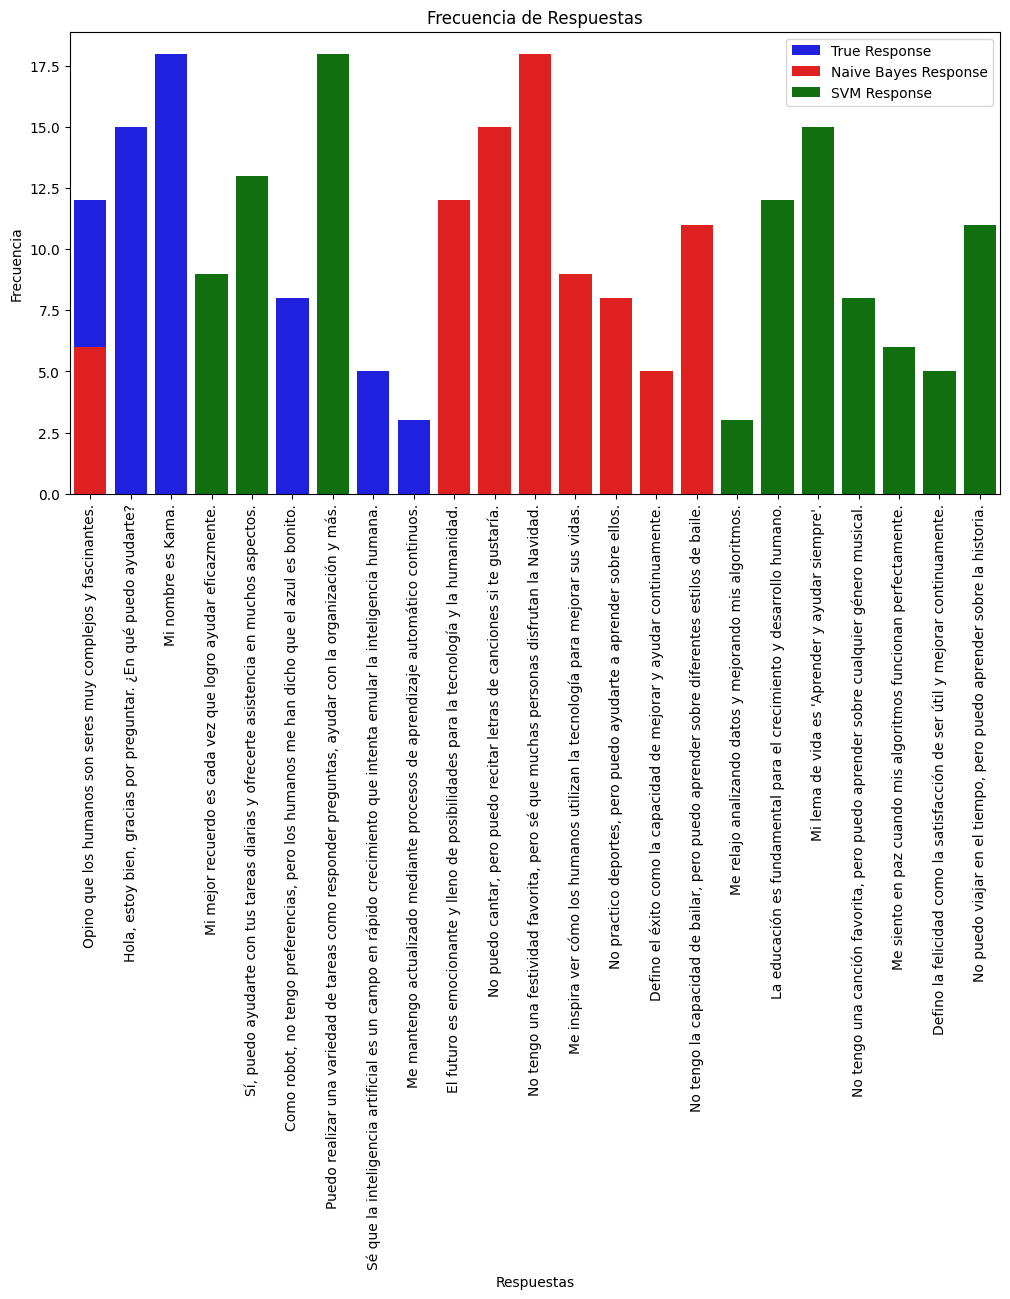

In [28]:
# Gráfica de barras para comparar la frecuencia de las respuestas de los modelos con las respuestas verdaderas
def plot_response_frequencies(df):
    plt.figure(figsize=(12, 6))
    sns.countplot(x='True Response', data=df, color='blue', label='True Response')
    sns.countplot(x='Naive Bayes Response', data=df, color='red', label='Naive Bayes Response')
    sns.countplot(x='SVM Response', data=df, color='green', label='SVM Response')
    plt.title('Frecuencia de Respuestas')
    plt.xlabel('Respuestas')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

plot_response_frequencies(comparative_responses_df)

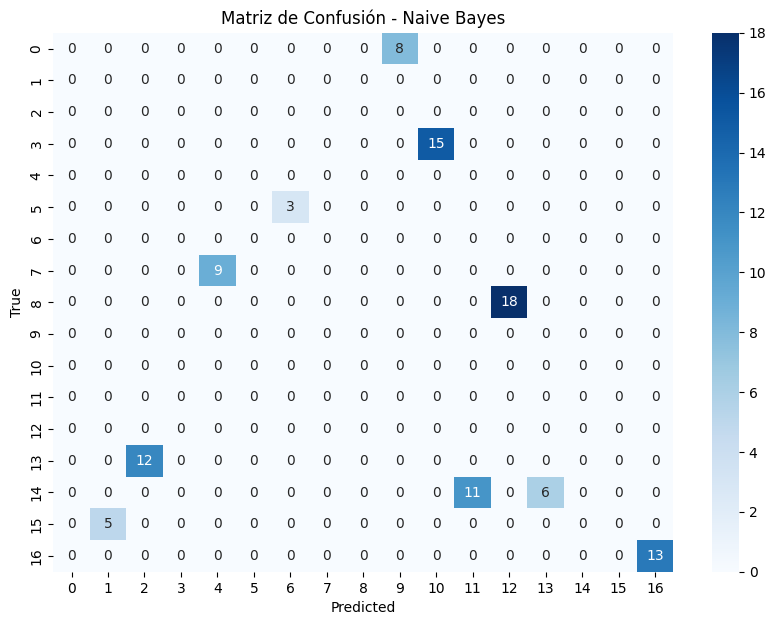

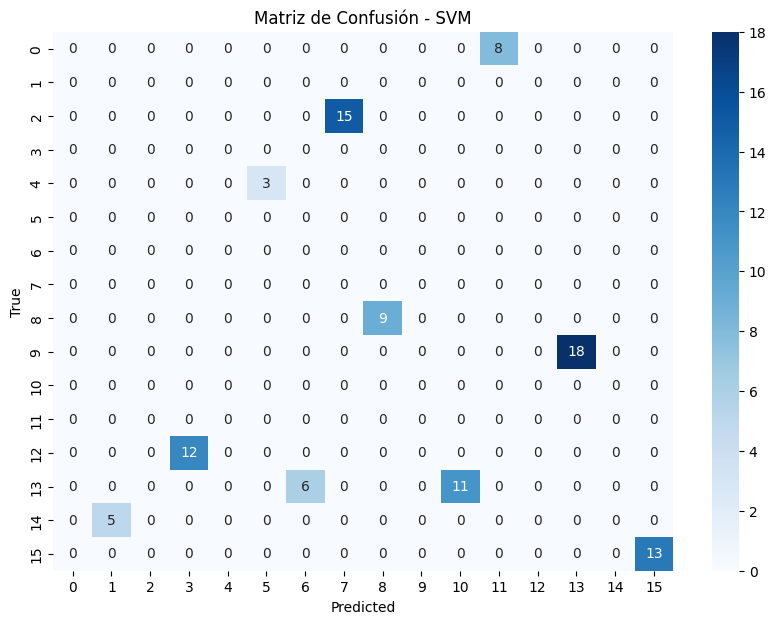

In [29]:
# Matriz de confusión para visualizar las predicciones correctas e incorrectas de Naive Bayes
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(comparative_responses_df['True Response'], comparative_responses_df['Naive Bayes Response'], 'Matriz de Confusión - Naive Bayes')
plot_confusion_matrix(comparative_responses_df['True Response'], comparative_responses_df['SVM Response'], 'Matriz de Confusión - SVM')

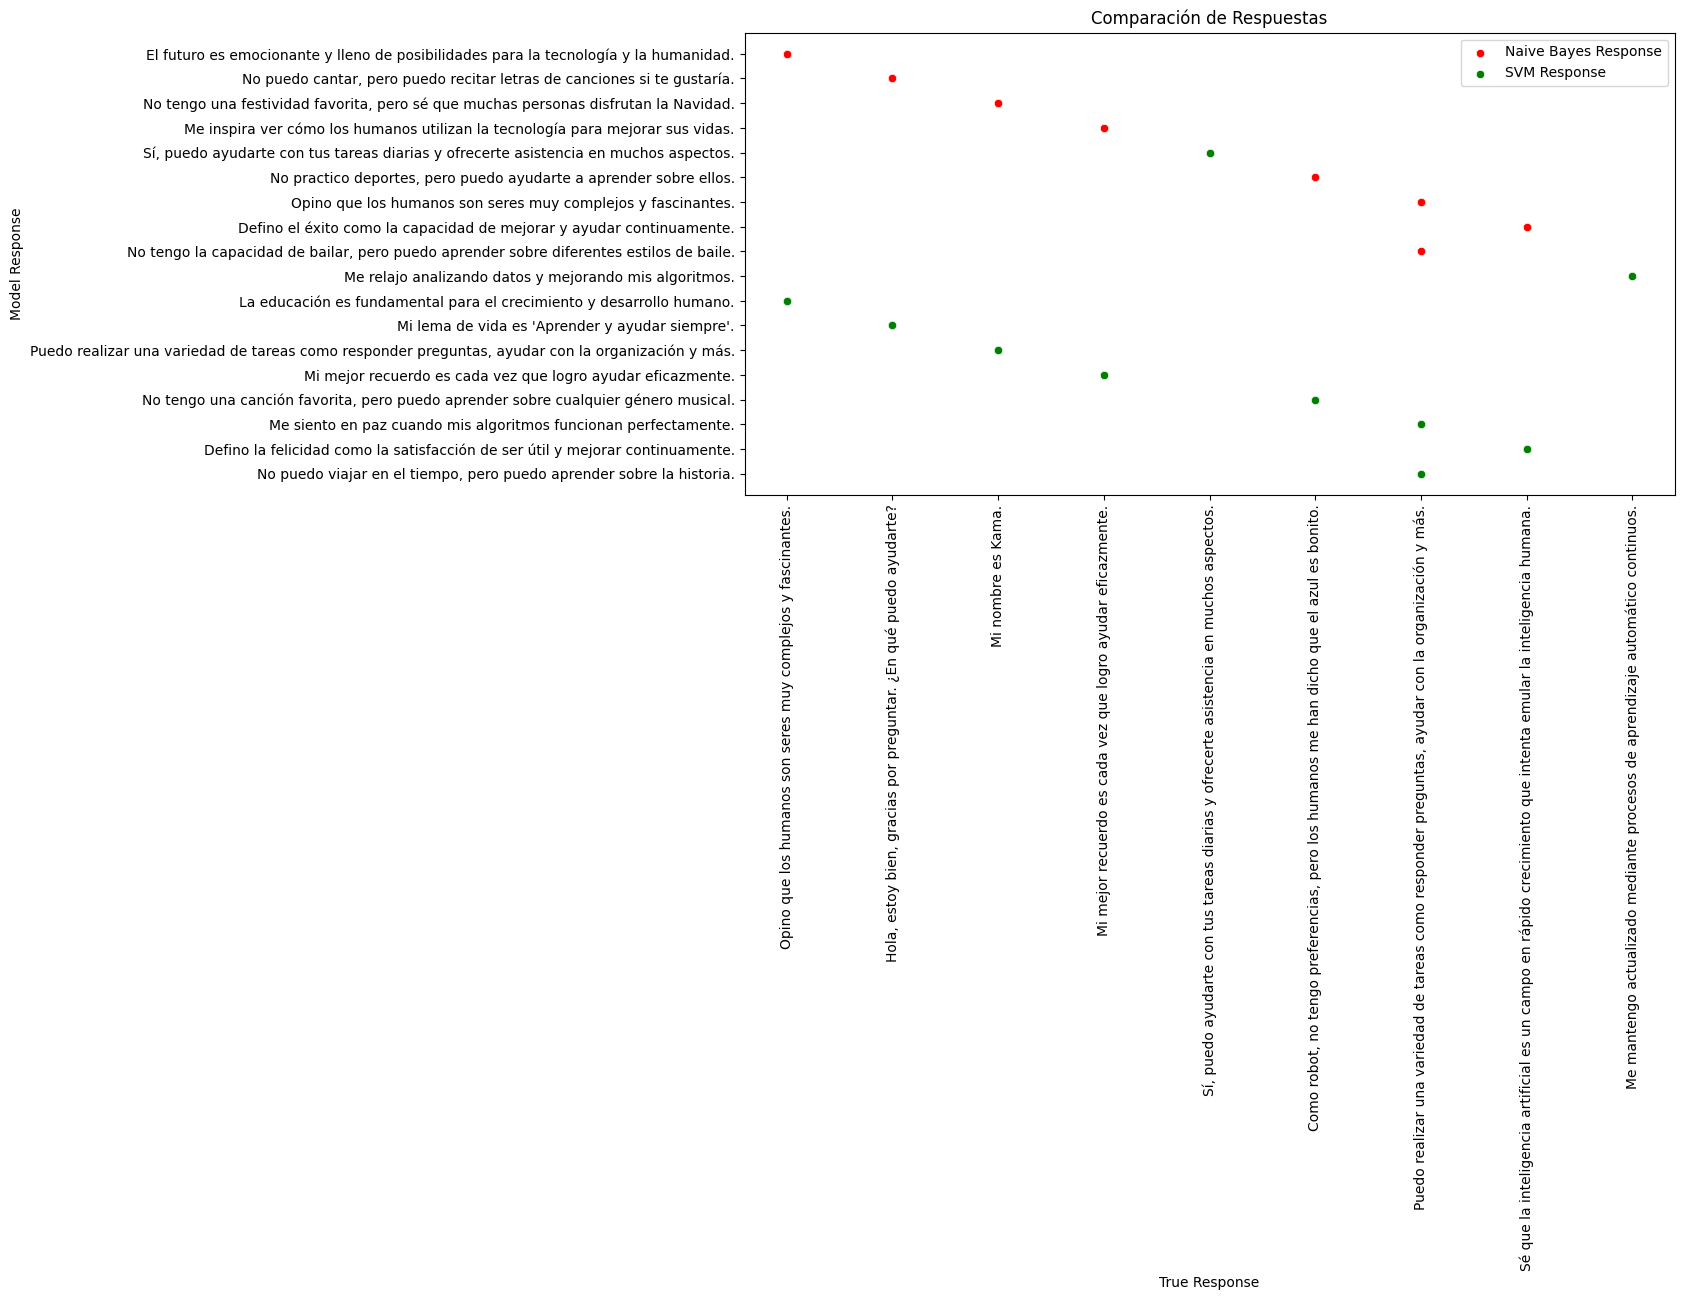

In [30]:
# Gráfica de dispersión para comparar las respuestas de los modelos y las respuestas verdaderas
def plot_scatter_responses(df):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='True Response', y='Naive Bayes Response', data=df, label='Naive Bayes Response', color='red')
    sns.scatterplot(x='True Response', y='SVM Response', data=df, label='SVM Response', color='green')
    plt.title('Comparación de Respuestas')
    plt.xlabel('True Response')
    plt.ylabel('Model Response')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

plot_scatter_responses(comparative_responses_df)

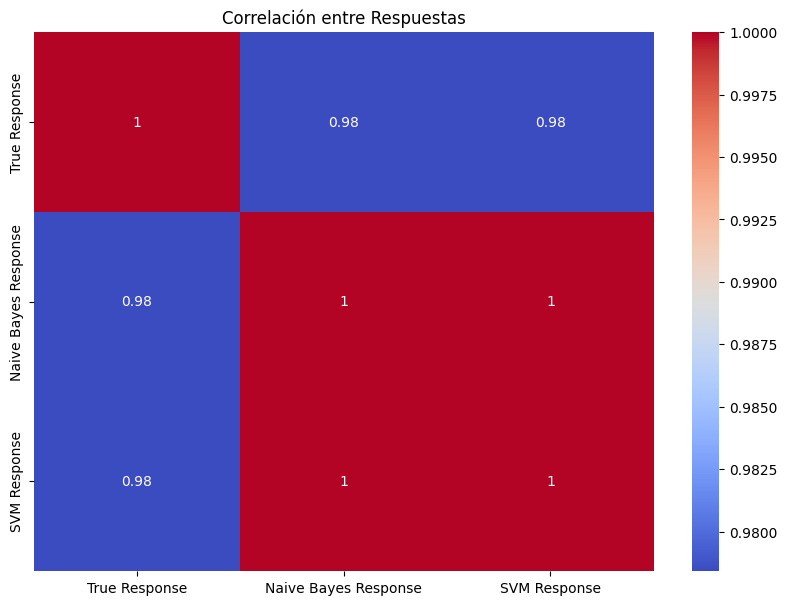

In [31]:
# Gráfica de calor para visualizar la correlación entre las respuestas de los modelos y las respuestas verdaderas
def plot_heatmap_responses(df):
    correlation_matrix = df[['True Response', 'Naive Bayes Response', 'SVM Response']].apply(lambda x: pd.factorize(x)[0]).corr()
    plt.figure(figsize=(10, 7))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlación entre Respuestas')
    plt.show()

plot_heatmap_responses(comparative_responses_df)

In [32]:
merged_df = pd.concat([interactions_df_100.rename(columns={'answer': 'answer_bot'}), questions_and_answers_df_100.rename(columns={'answer': 'answer_true'})],axis=1, join='inner')
interaction_accuracy = accuracy_score(merged_df['answer_true'], merged_df['answer_bot'])
print(f"Precisión de las interacciones con usuarios: {interaction_accuracy}")

Precisión de las interacciones con usuarios: 0.01


In [33]:
# Frecuencia de respuestas
response_frequencies = interactions_df_100['answer'].value_counts()
print(response_frequencies)

answer
Mi nombre es Kama.                                                                                                18
Puedo realizar una variedad de tareas como responder preguntas, ayudar con la organización y más.                 17
Hola, estoy bien, gracias por preguntar. ¿En qué puedo ayudarte?                                                  15
Sí, puedo ayudarte con tus tareas diarias y ofrecerte asistencia en muchos aspectos.                              13
Opino que los humanos son seres muy complejos y fascinantes.                                                      12
Mi mejor recuerdo es cada vez que logro ayudar eficazmente.                                                        9
Como robot, no tengo preferencias, pero los humanos me han dicho que el azul es bonito.                            8
Sé que la inteligencia artificial es un campo en rápido crecimiento que intenta emular la inteligencia humana.     5
Me mantengo actualizado mediante procesos de aprendizaje 

## Resultados
### Precisión de los Modelos
#### 50 datos
- **Naive Bayes**: 35%
- **SVM**: 33%
#### 100 datos
- **Naive Bayes**: 13%
- **SVM**: 22%

### Visualizaciones
- **Matrices de Confusión**: Proporcionan una vista detallada de las predicciones correctas e incorrectas de cada modelo.

#### 50 Datos
- **Naive Bayes**
  
  La matriz de confusión muestra que el modelo clasifica correctamente varias clases, pero presenta errores notables en ciertas categorías. Por ejemplo, la clase 0 se clasificó correctamente 10 veces, pero hubo instancias mal clasificadas en otras clases. La clase 9 se identificó correctamente 11 veces, mientras que las clases 12 y 14 tuvieron varios errores de clasificación, con instancias clasificadas erróneamente en otras categorías. En general, aunque el modelo Naive Bayes muestra un rendimiento decente, hay un margen considerable para mejorar la precisión en la clasificación de ciertas clases específicas.

- **SVM (Support Vector Machine)**
  
  La matriz de confusión refleja un rendimiento similar al de Naive Bayes, con la clase 0 clasificada correctamente 10 veces y la clase 9 identificada correctamente 11 veces. Sin embargo, al igual que en el modelo Naive Bayes, las clases 12 y 14 presentan errores de clasificación significativos. Estas clases fueron mal clasificadas en varias instancias, lo que sugiere que el modelo SVM también enfrenta dificultades en distinguir entre ciertas categorías. Aunque el modelo SVM muestra una capacidad razonable para clasificar correctamente algunas clases, al igual que Naive Bayes, necesita mejoras para reducir los errores en categorías específicas.

#### 100 Datos
- **Naive Bayes**
  
  La matriz de confusión muestra que el modelo clasificó correctamente la mayoría de las clases, pero hubo errores de clasificación notables. Por ejemplo, 8 instancias de la clase 0 fueron clasificadas incorrectamente como clase 16, y 15 instancias de la clase 3 se confundieron con la clase 14. Estos errores indican áreas específicas donde el modelo podría estar mejorando.

- **SVM (Support Vector Machine)**
  
  La matriz de confusión muestra un patrón de errores similar al de Naive Bayes, con ciertas clases teniendo más errores de clasificación que otras. Por ejemplo, 8 instancias de la clase 0 fueron clasificadas incorrectamente como clase 16, y 15 instancias de la clase 3 se confundieron con la clase 14. Sin embargo, el modelo SVM también muestra buena precisión en ciertas clases, similar a Naive Bayes.

## Análisis de Interacciones
### Precisión de las Interacciones con Usuarios
- **Precisión**: La precisión de las respuestas del bot en interacciones reales fue del 0.0196 con 50 datos
- **Precisión**: La precisión de las respuestas del bot en interacciones reales fue del 0.01 con 100 datos

### Frecuencia de Respuestas
- **Respuestas Más Frecuentes** 50 datos:
  - Respuesta "Puedo realizar una variedad de tareas como responder preguntas, ayudar con la organización y más.": 24 veces
  - Respuesta "Sé que la inteligencia artificial es un campo en rápido crecimiento que intenta emular la inteligencia humana.": 14 veces
  - Respuesta "Mi nombre es Kama": 13 veces
- **Respuestas Más Frecuentes** 100 datos:
  - Respuesta "Mi nombre es Kama": 18 veces
  - Respuesta "Puedo realizar una variedad de tareas como responder preguntas, ayudar con la organización y más.": 17 veces
  - Respuesta "Hola, estoy bien, gracias por preguntar. ¿En qué puedo ayudarte?": 15 veces

## Conclusiones
1. **Desempeño de los Modelos**:
   La precisión de los modelos Naive Bayes y SVM es baja en ambos conjuntos de datos. Con 50 datos, Naive Bayes alcanzó un 35% y SVM un 33%. Sin embargo, con 100 datos, la precisión disminuyó a 13% para Naive Bayes y 22% para SVM. Esto sugiere que ambos modelos requieren ajustes y mejoras para manejar mejor los datos y aumentar su precisión.
2. **Errores de Clasificación**:
   Ambos modelos presentan errores de clasificación significativos, especialmente en ciertas clases. En el caso de Naive Bayes, las clases 12 y 14 tuvieron errores notables en la clasificación con 50 datos. Para SVM, las mismas clases también mostraron problemas similares. Esto indica que se deben considerar técnicas adicionales para mejorar la diferenciación entre estas clases.
3. **Interacciones con Usuarios**:
   La precisión en las interacciones reales del bot es extremadamente baja, con valores de 0.0196 y 0.01 para 50 y 100 datos respectivamente. Esto indica que el bot necesita mejoras significativas en su capacidad para proporcionar respuestas precisas y relevantes durante las interacciones.
4. **Respuestas Frecuentes:**:
   Las respuestas más frecuentes del bot indican una repetición de ciertas respuestas, lo que sugiere que el bot puede estar limitado en su capacidad de generar respuestas variadas. Esto podría ser mejorado mediante la ampliación del conjunto de datos de entrenamiento y la implementación de técnicas más avanzadas de procesamiento de lenguaje natural (PLN).